In [1]:
import pandas as pd
import numpy as np
from typing import Dict, Tuple, List, Any

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from architecture_new_new.deep_binary_classifier import DeepBinaryClassifier
from architecture_new_new.ripper_node_reduced import make_ripper_node_reduced

In [2]:
df = pd.read_csv("./data/10_bit_artificial/107.csv")
X = df.drop(columns="class").to_numpy(bool)
y = df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (819, 10), X_test: (205, 10)
y_train: (819,), y_test: (205,)


In [3]:
config = dict(
    layer_node_counts=[16]*3 + [1],
    layer_bit_counts=[8]*4,
    seed=42
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node_reduced, jobs=8)
_ = net.fit(X_train, y_train)

pred_test = net.predict(X_test)
acc_before = accuracy_score(y_test, pred_test)
print(f"Accuracy (before pruning): {acc_before:.6f}")

Accuracy (before pruning): 0.990244


In [4]:
# 3) DESCRIPTION SYNTAX + HELPERS

NodeKey = Tuple[int, int]  # (layer_number, node_index) with inputs at layer 0
# layers are indexed as: 0 = inputs, 1..L = actual network layers

def describe_architecture_graph(net) -> Dict[str, Any]:
    """
    Returns a compact architecture description that is stable for drawing/export:
      - 'inputs': sorted list of input indices that reach the outputs
      - 'layers': list of dicts per layer starting with the input layer (l=0),
                  each dict has {'layer': l, 'nodes': [indices]}
      - 'connections': mapping (l,i) -> list[int] of indices in layer l-1
      - 'node_meta': optional extras per node (e.g., selected columns, rule text)
    """
    if not hasattr(net, "layers") or not net.layers:
        raise RuntimeError("Network not fitted; no layers to describe.")

    # 1) Full connection map for non-input layers:
    #    Keys are 1..L, values are indices into previous layer (0..n-1)
    connections: Dict[NodeKey, List[int]] = {
        (l+1, i): node.X_cols.tolist()
        for l, layer in enumerate(net.layers)
        for i, node in enumerate(layer)
    }

    # 2) Backward traversal from final node (assuming output node index 0)
    last_L = len(net.layers)  # last layer id (1..last_L)
    stack = [(last_L, 0)]
    visited = set(stack)

    while stack:
        l, i = stack.pop()
        for c in connections.get((l, i), []):
            prev = (l-1, c)
            if prev not in visited:
                visited.add(prev)
                stack.append(prev)

    # 3) Relevant input indices (layer 0)
    relevant_inputs = sorted(j for (l, j) in visited if l == 0)

    # 4) Layer nodes that are actually visited (input layer + others)
    layers_desc = []
    # input layer (l=0):
    layers_desc.append({'layer': 0, 'nodes': relevant_inputs})

    # non-input layers:
    for l, layer in enumerate(net.layers, start=1):
        kept = sorted(i for i, _ in enumerate(layer) if (l, i) in visited)
        layers_desc.append({'layer': l, 'nodes': kept})

    # 5) Filter connections to visited subset
    filtered_connections = {k: v for k, v in connections.items() if k in visited}

    # 6) Optional node metadata (safe, compact)
    node_meta: Dict[NodeKey, Dict[str, Any]] = {}
    for l, layer in enumerate(net.layers, start=1):
        for i, node in enumerate(layer):
            if (l, i) not in visited:
                continue
            meta = {
                'cols': node.X_cols.tolist(),
                'bits': int(node.X_cols.size),
            }
            # if it's a RipperNode, attach a compact rule text (optional)
            if hasattr(node, "get_expr"):
                try:
                    rule = node.get_expr()
                    # keep it concise
                    meta['rule'] = str(rule)
                except Exception:
                    meta['rule'] = None
            node_meta[(l, i)] = meta

    return {
        'inputs': relevant_inputs,
        'layers': layers_desc,
        'connections': filtered_connections,
        'node_meta': node_meta
    }

def relevant_inputs_from_desc(desc: Dict[str, Any]) -> List[int]:
    """Convenience: extract relevant input indices from the description."""
    return list(desc['inputs'])

def print_architecture_summary(desc: Dict[str, Any]) -> None:
    """Compact text summary for quick inspection."""
    print("Inputs used:", desc['inputs'])
    print("Layers:")
    for layer in desc['layers']:
        l = layer['layer']
        nodes = layer['nodes']
        print(f"  L{l}: {len(nodes)} node(s) -> {nodes}")
    print(f"Connections: {len(desc['connections'])} nodes with incoming edges")

In [5]:
desc_before = describe_architecture_graph(net)
print_architecture_summary(desc_before)

Inputs used: [0, 1, 2, 3, 4, 5, 6, 7]
Layers:
  L0: 8 node(s) -> [0, 1, 2, 3, 4, 5, 6, 7]
  L1: 8 node(s) -> [0, 1, 2, 3, 4, 5, 6, 7]
  L2: 7 node(s) -> [0, 1, 2, 3, 4, 5, 6]
  L3: 2 node(s) -> [3, 6]
  L4: 1 node(s) -> [0]
Connections: 18 nodes with incoming edges


In [6]:
def reduce_ripper_net(net) -> "DeepBinaryClassifier":
    """
    In-place reduction of all nodes (cuts backlinks).
    Does not change layer sizes; pruning is done separately.
    """
    for layer in net.layers:
        for node in layer:
            # only nodes that support reduction; harmless if others are present
            if hasattr(node, "reduce_expr"):
                node.reduce_expression()
    return net


# 1) Reduce all nodes
red_net = reduce_ripper_net(net)
#red_net = net

# 2) Prune unused nodes (keeps all current final outputs; reindexes X_cols)
red_net.prune(verbose=True)

Before pruning: [16, 16, 16, 1]
After pruning:  [16, 16, 8, 1]


In [7]:

# 3) Evaluate
pred_test = red_net.predict(X_test)
acc_red = accuracy_score(y_test, pred_test)
print(f"Reduced network accuracy (after reduction): {acc_red:.4f}")
print("Δ accuracy after reduction:", float(acc_red - acc_before))

Reduced network accuracy (after reduction): 0.9902
Δ accuracy after reduction: 0.0


In [8]:
# 6) RE-DESCRIBE ARCHITECTURE (AFTER)

desc_after = describe_architecture_graph(net)
print_architecture_summary(desc_after)

Inputs used: [0, 1, 2, 3, 4, 5, 6, 7]
Layers:
  L0: 8 node(s) -> [0, 1, 2, 3, 4, 5, 6, 7]
  L1: 7 node(s) -> [0, 1, 2, 3, 4, 5, 6]
  L2: 3 node(s) -> [1, 3, 6]
  L3: 2 node(s) -> [3, 6]
  L4: 1 node(s) -> [0]
Connections: 13 nodes with incoming edges


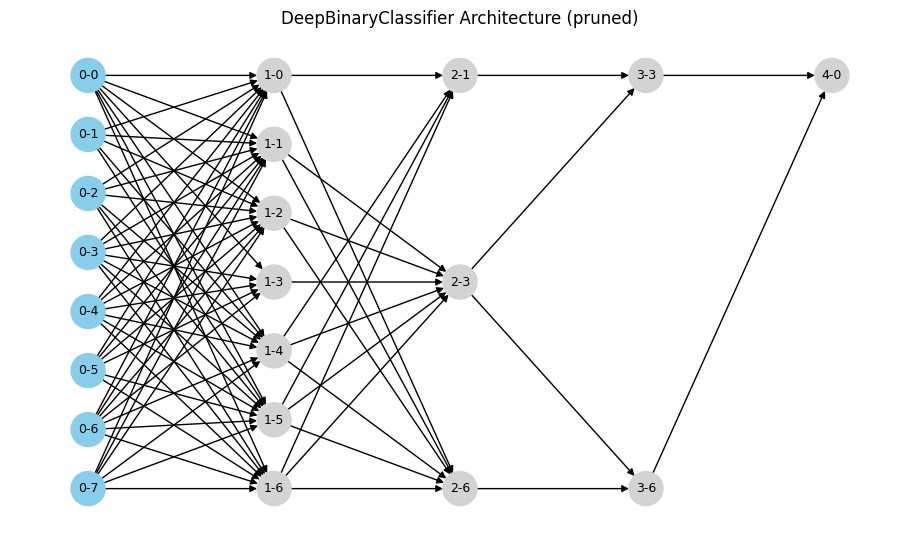

In [9]:
# 7) DRAW ARCHITECTURE FROM DESCRIPTION (NETWORKX)

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def to_networkx_from_description(desc, include_labels=True):
    """
    Build a DiGraph and a position map from the architecture description.
    Node labels are 'layer-index' (e.g., '0-5' for input 5, '3-2' for layer 3 node 2).
    """
    G = nx.DiGraph()
    pos = {}

    # 1) Gather per-layer node index lists
    layer_nodes = {}
    for layer_block in desc['layers']:
        l = layer_block['layer']
        layer_nodes[l] = list(layer_block['nodes'])

    # 2) Position nodes evenly by layer
    for l in sorted(layer_nodes.keys()):
        indices = layer_nodes[l]
        if not indices:
            continue
        ys = np.linspace(0, -1, len(indices))
        for y, idx in zip(ys, indices):
            label = f"{l}-{idx}"
            G.add_node(label)
            pos[label] = (l, y)

    # 3) Add edges from connections
    for (l, i), cols in desc['connections'].items():
        to_label = f"{l}-{i}"
        for c in cols:
            from_label = f"{l-1}-{c}"
            if from_label in G and to_label in G:
                G.add_edge(from_label, to_label)

    return G, pos

def draw_architecture(desc, title="DeepBinaryClassifier Architecture (pruned)"):
    G, pos = to_networkx_from_description(desc)

    # Input nodes colored differently
    node_colors = []
    for label in G.nodes():
        layer_id = int(label.split('-')[0])
        node_colors.append('skyblue' if layer_id == 0 else 'lightgray')

    plt.figure(figsize=(9, 5))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=600,
        font_size=9,
        edge_color='k'
    )
    plt.title(title)
    plt.axis('off')
    plt.show()

draw_architecture(desc_after)

In [10]:
# 8) OPTIONAL: SHOW METADATA (e.g., rules) FOR DEEPEST LAYER

# find final layer id
final_layer = max(layer['layer'] for layer in desc_after['layers'])
deep_nodes = desc_after['layers'][-1]['nodes']
print(f"Final layer L={final_layer}, nodes: {deep_nodes}")

for i in deep_nodes[:5]:  # show up to 5
    key = (final_layer, i)
    meta = desc_after['node_meta'].get(key, {})
    print(f"\nNode (L={final_layer}, i={i}) meta:")
    for k, v in meta.items():
        if k == 'rule' and v is not None and len(v) > 300:
            print(f"  {k}: {v[:300]} ...")
        else:
            print(f"  {k}: {v}")


Final layer L=4, nodes: [0]

Node (L=4, i=0) meta:
  cols: [3, 6]
  bits: 2
  rule: L3N10 | L3N6
